In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

np.random.seed(10)

In [2]:
def view_images(dataset, size):
    images, labels = dataset
    assert images.shape[0] == labels.shape[0]

    num_images = images.shape[0]
    num_cols = 3
    num_rows = np.ceil(num_images / num_cols).astype("int")
    plt.figure(figsize=size)
    for i in range(num_images):
        image = images[i]
        label = labels[i]
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(np.array(image, dtype="float"))
        plt.title("Number: " + str(label))
        plt.axis("off")

In [3]:
def normalise(dataset):
    # Scale images to the [0, 1] range
    dataset = dataset.astype("float32") / 255
    # Make sure images have shape (28, 28, 1)
    return np.expand_dims(dataset, -1)

In [31]:
def sample(dataset, fraction):
    def _get_sample_mask():
        num_of_samples = np.round(num_datapoints*fraction).astype("int")
        mask = np.zeros(num_datapoints, dtype="bool")
        mask[:num_of_samples] = True
        np.random.default_rng().shuffle(mask)
        return mask

    x, y = dataset
    assert x.shape[0] == y.shape[0]

    num_datapoints = x.shape[0]
    # Create a mask of 0s and 1s with the right distribution (as requested in fraction)
    sample_mask = _get_sample_mask()
    # Sample from the dataset, using the mask
    x_sampled = x.compress(sample_mask, axis=0)
    y_sampled = y.compress(sample_mask, axis=0)
    # Flip the mask and do it again to get the not sampled
    x_not_sampled = x.compress(1 - sample_mask, axis=0)
    y_not_sampled = y.compress(1 - sample_mask, axis=0)
    """ Example
    If original dataset is: [1, 2, 3, 4, 5] with a fraction of 0.2
    We might get a sample_mask like [0, 0, 1, 0, 0].

    sampled will thus be [3]
    and not_sampled [1, 2, 4, 5], by flipping the bits to [1, 1, 0, 1, 1]
    """
    return (x_sampled, y_sampled), (x_not_sampled, y_not_sampled)

def choice(dataset, size):
    x, y = dataset
    assert x.shape[0] == y.shape[0]

    num_datapoints = x.shape[0]
    mask = np.zeros(num_datapoints).astype("bool")
    mask[:size] = True
    np.random.default_rng().shuffle(mask)
    return x.compress(mask, axis=0), y.compress(mask, axis=0)

In [5]:
def print_dataset_summary(name, dataset):
    print(name + " shape:", dataset.shape)

x_augment shape: (6000, 28, 28, 1)
x_train shape: (54000, 28, 28, 1)
y_train shape: (54000,)
x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1)


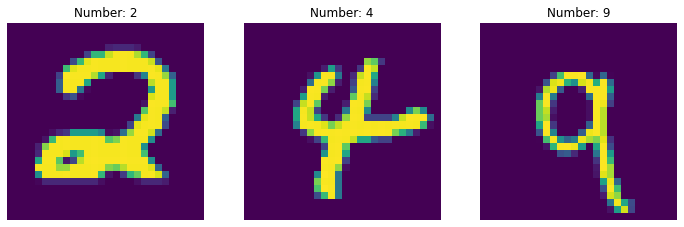

In [36]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# transform only a sample of the data
(x_augment, y_augment), (x_train, y_train) = sample((x_train, y_train), 0.1)

# normalise training data
x_train = normalise(x_train)
x_augment = normalise(x_augment)
x_test = normalise(x_test)

print_dataset_summary("x_augment", x_augment)

# augment data
# asdfasdf
view_images(choice((x_augment, y_augment), 3), (12, 12))

# put it all back together again
print_dataset_summary("x_train", x_train)
print_dataset_summary("y_train", y_train)
x_train = np.concatenate((x_train, x_augment))
y_train = np.concatenate((y_train, y_augment))

print_dataset_summary("x_train", x_train)
print_dataset_summary("y_train", y_train)
print_dataset_summary("x_test", x_test)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

assert y_train.shape[0] == x_train.shape[0]

In [7]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

In [8]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
43/43 [==============================] - 1s 24ms/step - loss: 1.9625 - accuracy: 0.3715 - val_loss: 0.4617 - val_accuracy: 0.8850
Epoch 2/15
43/43 [==============================] - 1s 17ms/step - loss: 0.6332 - accuracy: 0.7943 - val_loss: 0.2570 - val_accuracy: 0.9233
Epoch 3/15
43/43 [==============================] - 1s 17ms/step - loss: 0.3754 - accuracy: 0.8876 - val_loss: 0.1740 - val_accuracy: 0.9583
Epoch 4/15
43/43 [==============================] - 1s 17ms/step - loss: 0.2636 - accuracy: 0.9241 - val_loss: 0.1443 - val_accuracy: 0.9650
Epoch 5/15
43/43 [==============================] - 1s 17ms/step - loss: 0.2098 - accuracy: 0.9388 - val_loss: 0.1306 - val_accuracy: 0.9683
Epoch 6/15
43/43 [==============================] - 1s 16ms/step - loss: 0.1893 - accuracy: 0.9427 - val_loss: 0.1075 - val_accuracy: 0.9733
Epoch 7/15
43/43 [==============================] - 1s 16ms/step - loss: 0.1649 - accuracy: 0.9515 - val_loss: 0.1055 - val_accuracy: 0.9717
Epoch 8/15
43

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.08510737866163254
Test accuracy: 0.9735999703407288
